based on: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

## The Data

In [85]:
from keras.datasets.cifar10 import load_data

(dataset, _), (_, _) = load_data()

print("Dataset", dataset.shape)

Dataset [[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80  62]
   [ 71  73  61]]

  [[140 155 164]
   [139 146 149]
   [115 115 112]
   ...
   [ 79  82  64]
   [ 68  70  55]
   

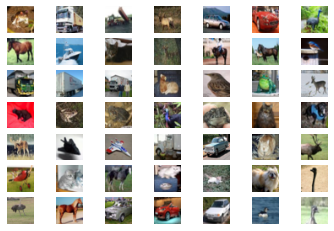

In [86]:
import matplotlib.pyplot as plt

for i in range(49):
    plt.subplot(7, 7, 1 + i)
    plt.axis("off")
    plt.imshow(dataset[i])

plt.show()

## The Model

In [87]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)

if tf.test.gpu_device_name():
    print(f"Default GPU Device: {tf.test.gpu_device_name()}")

In [88]:
def define_discriminator(in_shape=(32, 32, 3)):
    model = tf.keras.Sequential()
    # normal
    model.add(Conv2D(64, (3, 3), padding="same", input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model


discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_73 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 4, 4, 256)       

In [89]:
def define_generator(latent_dim):
    model = tf.keras.Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3, 3), activation="tanh", padding="same"))
    return model


latent_dim = 100
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 16, 16, 128)     

In [90]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model


gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_31 (Sequential)   (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_30 (Sequential)   (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


## Training

In [91]:
import numpy as np

def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = tf.ones((n_samples, 1))
    return X, y


def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    return x_input.reshape(n_samples, latent_dim)


def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y
    
    
def save_plot(examples, epoch, n=7):
    examples = (examples + 1) / 2
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis("off")
        plt.imshow(examples[i])
    # filename = "generated_plot_e%03d" % (epoch + 1)
    # plt.savefig(filename)
    # plt.close()


def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)

    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

    print(f">Accuracy real: {acc_real * 100}%, fake: {acc_fake * 100}%")
    save_plot(x_fake, epoch)
    # filename = "generator_model_%03d.h5" % (epoch + 1)
    # generator.save(filename)


def train(generator, discriminator, gan, dataset, latent_dim, epochs=200, batch_size=128):
    batches_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        for batch in range(batches_per_epoch):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = discriminator.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, batch_size)
            # create inverted labels for the fake samples
            y_gan = tf.ones((batch_size, 1))
            # update the generator via the discriminator's error
            g_loss = gan.train_on_batch(X_gan, y_gan)
            # summarice loss on this batch
            print(f">{epoch + 1}, {batch + 1}/{batches_per_epoch}, d1={d_loss1}, d2={d_loss2}, g={g_loss}")
        
        if (epoch + 1) % 10 == 0:
            summarize_performance(i, generator, discriminator, dataset, latent_dim)

In [92]:
latent_dim = 100
train(generator, discriminator, gan, dataset, latent_dim)

>1, 1/390, d1=2.7200024127960205, d2=0.6952590346336365, g=0.6917651295661926
>1, 2/390, d1=1.567785140534246e-14, d2=0.6962333917617798, g=0.6916345357894897
>1, 3/390, d1=8.627985152998008e-06, d2=0.6969375014305115, g=0.6913167834281921
>1, 4/390, d1=1.1518844075908419e-05, d2=0.6988047361373901, g=0.6896823644638062
>1, 5/390, d1=3.7694981164788544e-17, d2=0.7022801041603088, g=0.6863270998001099
>1, 6/390, d1=1.702181859806726e-17, d2=0.7087447643280029, g=0.6790015697479248
>1, 7/390, d1=3.2596060164023605e-20, d2=0.7224840521812439, g=0.6669209003448486
>1, 8/390, d1=2.1653246687000638e-13, d2=0.7460755109786987, g=0.646483302116394
>1, 9/390, d1=1.1220790635399917e-20, d2=0.7756608724594116, g=0.6224079132080078
>1, 10/390, d1=1.3607471801077028e-17, d2=0.8127363920211792, g=0.5943185091018677
>1, 11/390, d1=5.852282092093375e-14, d2=0.8466254472732544, g=0.5755167603492737
>1, 12/390, d1=5.2403882015022996e-14, d2=0.8623762130737305, g=0.5641970634460449
>1, 13/390, d1=5.01636

KeyboardInterrupt: 

## Results

In [ ]:
def create_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis("off")
        plt.imshow(examples[i, :, :])
    plt.show()


latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
X = (X + 1) / 2
create_plot(X, 10)